In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, make_axis_great_again, plot_metrics, plot_losses, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '12.05_20.05_near_complete_pipeline'

In [26]:
def plot_job(ax, job_id, title, training_batch_size, metrics_ylim):
    exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(current_milestone / '{}.out'.format(job_id))
    batch_amount_per_epoch = np.ceil(train_data_amount / training_batch_size)
    n_epochs = int(5e2)  # len(epochs)
    xrange = np.arange(1, n_epochs + 1) * batch_amount_per_epoch
    
    plot_losses(
        ax, epochs, xrange,
        normalize_loss=(0, 1),
        title=title, xlabel='# batch iterations'
    )
    
    plot_metrics(
        ax.twinx(), epochs, xrange,
        train_metric_ylim=metrics_ylim,
        eval_metric_ylim=metrics_ylim,
        metric_ylabel='average MPJPE relative to pelvis (mm)',
    )
    
    # plot_lr(ax.twinx(), lr_reductions, batch_amount_per_epoch)
    
    make_axis_great_again(ax, xlim=xrange, ylim=[0, 1], hide_y=True)
    
    
def plot_jobs(jobs, titles, training_batch_size=8, metrics_ylim=[0, 1e2]):
    fig, axis = get_figa(len(jobs), 1, heigth=12, width=30)  # 1 job foreach row
    
    for ax, job_id, title in zip(axis.ravel(), jobs, titles):
        plot_job(ax, job_id, title, training_batch_size, metrics_ylim)

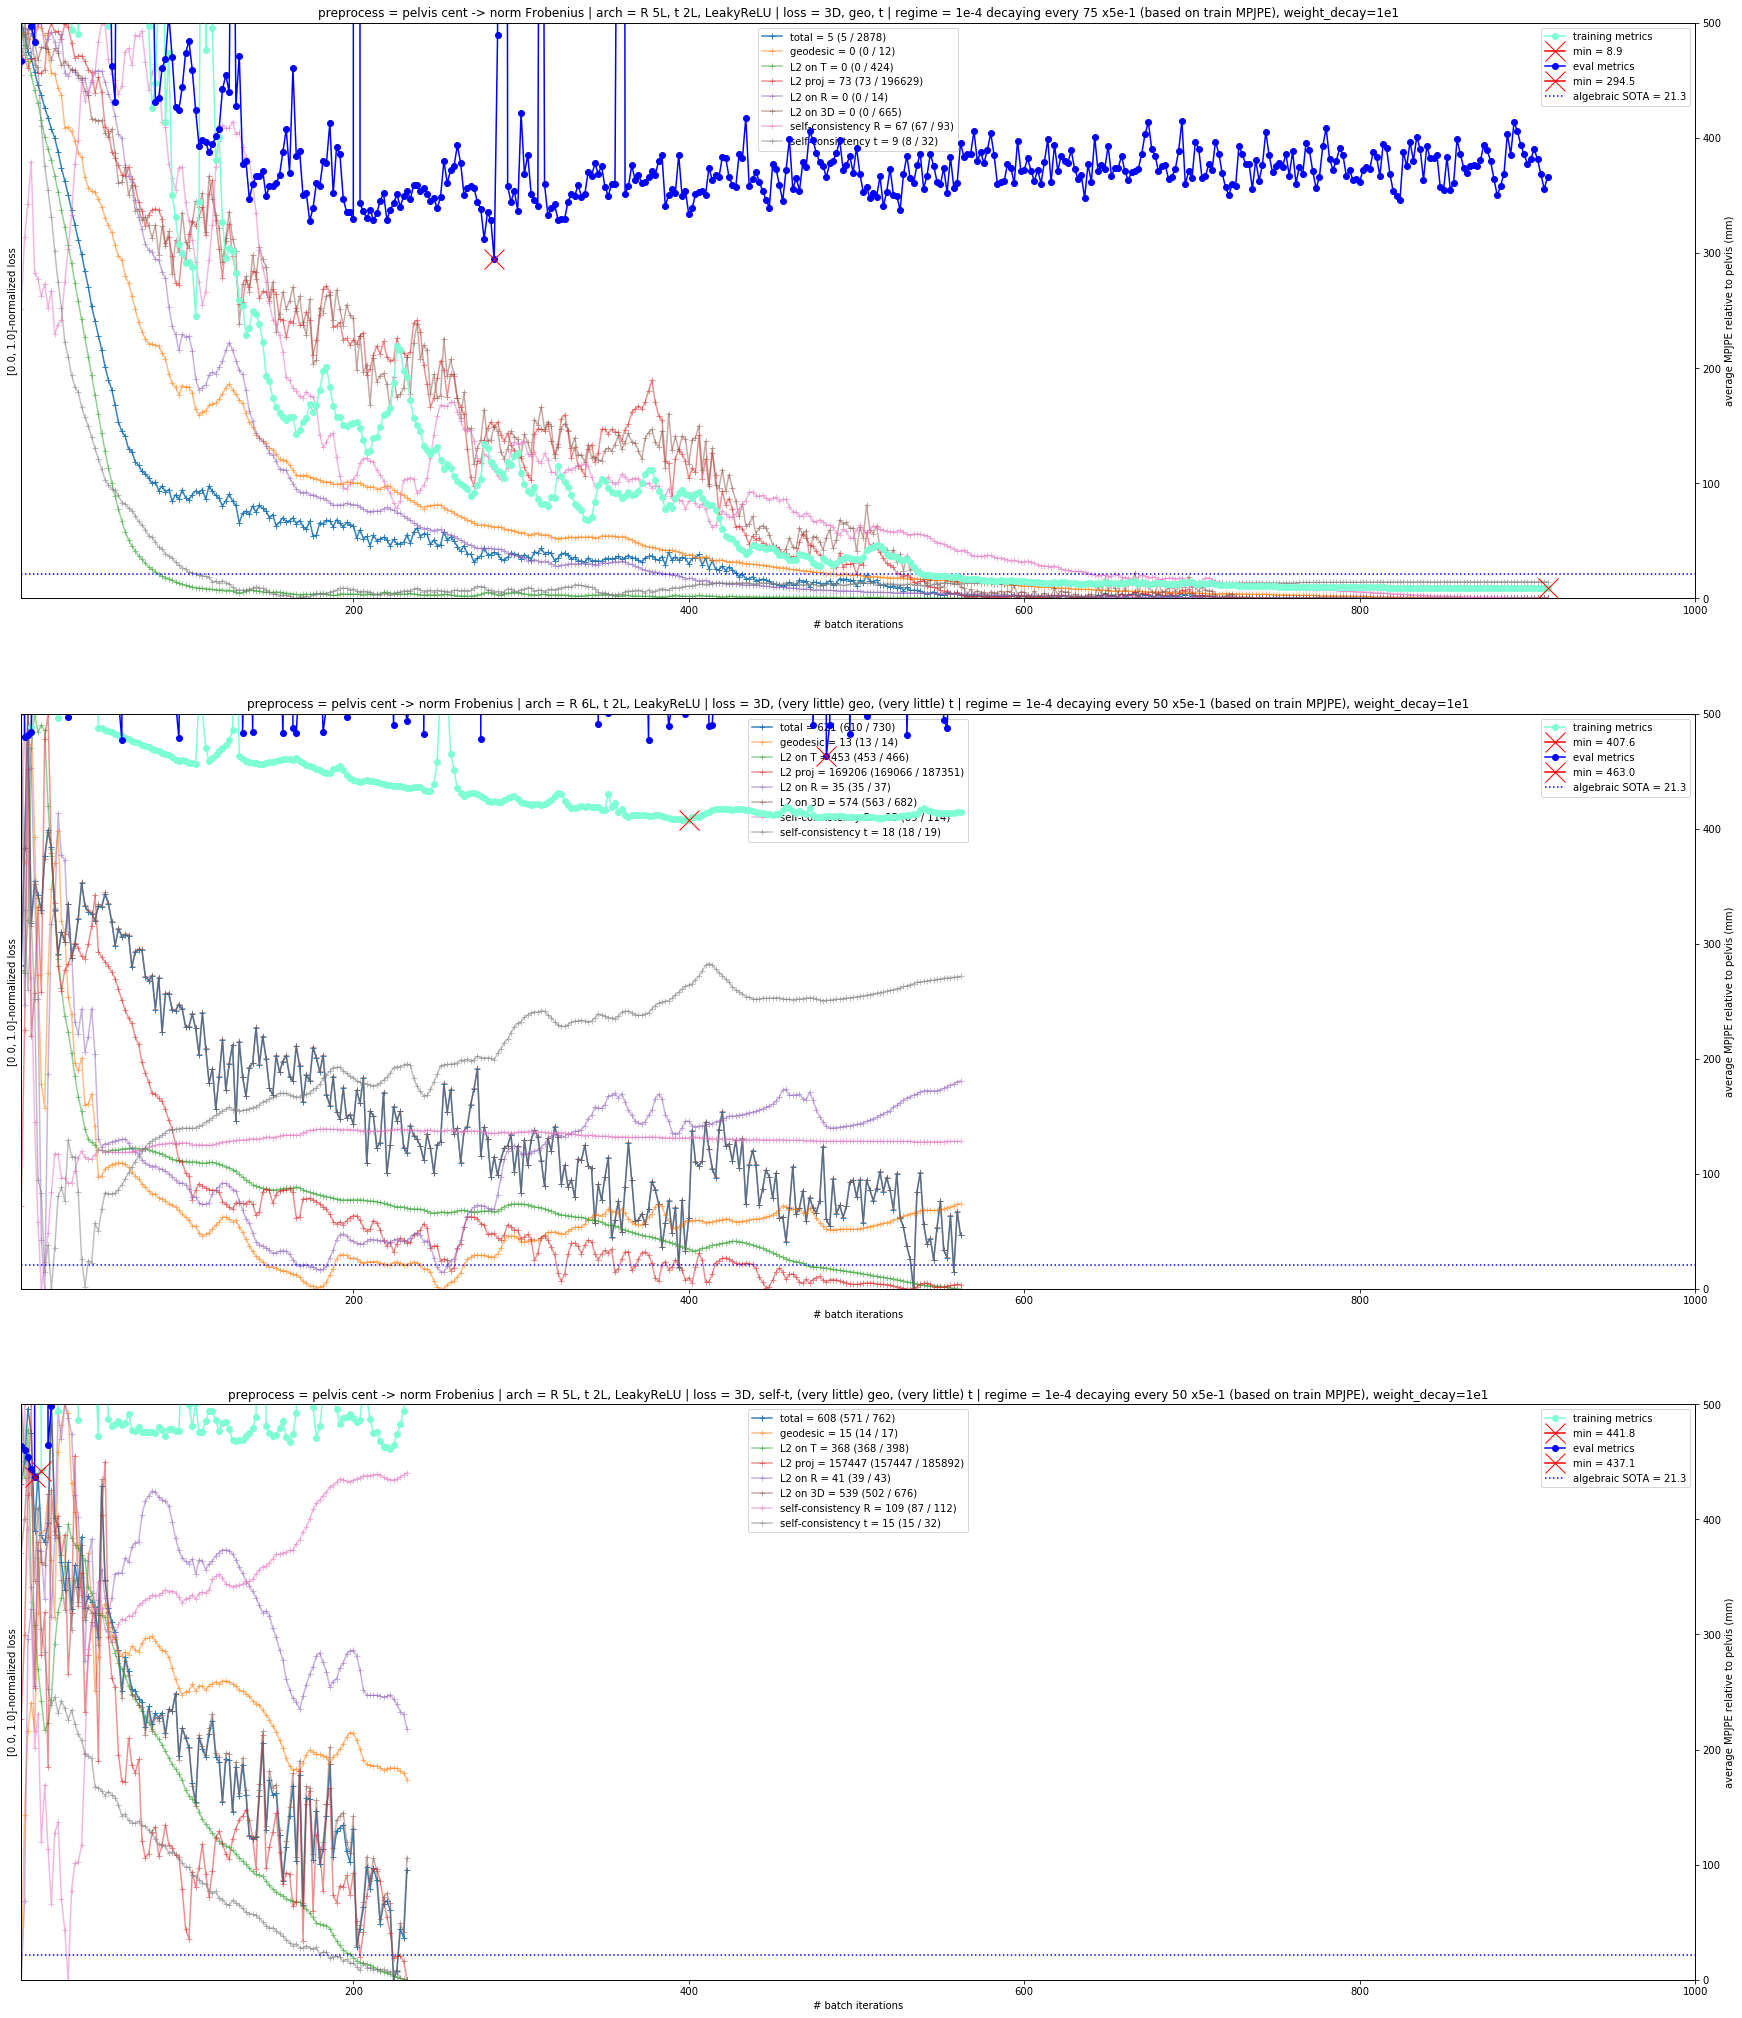

In [32]:
title = 'preprocess = {} | arch = {} | loss = {} | regime = {}'
common_setup = 'KISS (normalizing KPs), no lr decay'
jobs = list(zip(*[
    # ('15838524', title.format('pelvis cent -> norm Frobenius', 'no second BN, share ws', '3D, self-R, self-t', '1e-4 decaying every 100 x4e-1 (based on train MPJPE) + weight_decay=2e1')),
    # ('15841917', title.format('pelvis cent -> norm Frobenius', 'no second BN, share ws + bs', '3D, self-R, self-t', '2e-4 decaying every 100 x4e-1 (based on train MPJPE) + weight_decay=2e1')),
    # ('15844877', title.format('pelvis cent -> norm Frobenius', 'no second BN, share ws + 2L-bs', '3D, self-R, self-t', '1e-4 decaying every 100 x4e-1 (based on train MPJPE)')),
    # ('15845410', title.format('pelvis cent -> norm Frobenius', 'no second BN, share ws + 2L-bs', '3D, geo, t, self-R, self-t', '1e-4 decaying every 100 x4e-1 (based on train MPJPE)')),
    # ('15848734', title.format('pelvis cent -> norm Frobenius', 'no second BN, share ws + 2L-bs', '3D, proj, geo, t, self-R, self-t', '1e-4 decaying every 100 x4e-1 (based on train MPJPE)')),
    
    # baseline
    ('15854643', title.format('pelvis cent -> norm Frobenius', 'R 5L, t 2L, LeakyReLU', '3D, geo, t', '1e-4 decaying every 75 x5e-1 (based on train MPJPE), weight_decay=1e1')),
    # proj ('15862449', title.format('pelvis cent -> norm Frobenius', 'R 4L, t 2L, LeakyReLU', 'proj, geo, t', '1e-4 decaying every 100 x5e-1 (based on train MPJPE), weight_decay=1e1')),
    ('15866085', title.format('pelvis cent -> norm Frobenius', 'R 6L, t 2L, LeakyReLU', '3D, (very little) geo, (very little) t', '1e-4 decaying every 50 x5e-1 (based on train MPJPE), weight_decay=1e1')),
    ('15866323', title.format('pelvis cent -> norm Frobenius', 'R 5L, t 2L, LeakyReLU', '3D, self-t, (very little) geo, (very little) t', '1e-4 decaying every 50 x5e-1 (based on train MPJPE), weight_decay=1e1')),
    # ('', title.format('pelvis cent -> norm Frobenius', 'R 5L, t 2L, LeakyReLU', 'proj, self-t, (very little) geo, (very little) t', '1e-4 decaying every 50 x5e-1 (based on train MPJPE), weight_decay=1e1')),

    # experiments
    # ('15781997', title.format('pelvis-cent -> norm L1', 'MLPResNet BN 5L1024U', '3D + self-R', '1e-4 decaying every 100 x8e-1 + weight_decay=1e1')),
    # ('15829357', title.format('pelvis cent -> norm L1', 'no second BN', '3D + self-R + self-t', '5e-5 decaying every 100 x7e-1 (based on train MPJPE) + weight_decay=1e1')),
    # ('15827642', title.format('pelvis cent -> norm Frobenius', 'no second BN', '3D + self-R + self-t', '1e-4 decaying every 100 x8e-1 (based on train MPJPE) + weight_decay=1e1')),
    # ('15832587', title.format('pelvis cent -> norm fro', 'no second BN, no bias', '3D + self-R + self-t', '1e-4 decaying every 100 x4e-1 (based on train MPJPE) + weight_decay=1e2')),
    # ('15840052', title.format('pelvis cent -> norm L1', 'no second BN, share ws', '3D + self-R + self-t', '1e-4 decaying every 100 x4e-1 (based on train MPJPE) + weight_decay=2e1')),
    # ('15840371', title.format('pelvis cent -> norm Frobenius', 'no second BN, 3 backbones', '3D + self-R + self-t', '2e-4 decaying every 100 x7e-1 + weight_decay=1e1')),
    # ('15840569', title.format('pelvis cent -> norm L1', 'no second BN, 3 backbones', '3D + self-R + self-t', '2e-4 decaying every 100 x7e-1 + weight_decay=1e1')),
]))  # human readable form

plot_jobs(jobs[0], jobs[1], metrics_ylim=[0, 5e2])  # .png